# Objetivos
- Reducir falsos positivos en perfiles con transacciones complejas
- Evitar alertas innecesarias en clientes con comportamiento legítimo pero no convencional.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# EDA

In [2]:
df = pd.read_csv("feature_engineering_work/dataset_feature_engineering.csv")
df

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,first_time_at_merchant,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,True,78.773821,1,1,0,2019,5,4,2,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,True,30.216618,1,1,0,2019,4,4,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,True,108.102912,1,1,0,2019,4,3,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,True,95.685115,1,1,0,2019,1,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,True,77.702395,1,1,0,2019,6,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,...,False,77.032467,12,3,23,2020,6,3,1,1
1852390,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,...,False,100.023736,12,3,23,2020,5,3,1,1
1852391,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,...,False,80.887812,12,3,23,2020,10,7,1,2
1852392,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,...,False,53.060882,12,3,23,2020,4,2,2,1


In [3]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,...,count_month_shopping_net,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,...,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03,...,4.567241e+00,7.610956e+01,7.152067e+00,2.967456e+00,1.280612e+01,2.019501e+03,5.298079e+00,3.150459e+00,1.389109e+00,1.655442e+00
std,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02,...,4.575502e+00,2.909273e+01,3.424954e+00,2.197983e+00,6.815753e+00,4.999996e-01,3.094345e+00,1.865369e+00,6.722559e-01,9.025901e-01
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00,...,0.000000e+00,2.227351e-02,1.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00,...,1.000000e+00,5.534198e+01,4.000000e+00,1.000000e+00,7.000000e+00,2.019000e+03,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00
50%,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00,...,3.000000e+00,7.824823e+01,7.000000e+00,3.000000e+00,1.400000e+01,2.020000e+03,5.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
75%,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00,...,7.000000e+00,9.847204e+01,1.000000e+01,5.000000e+00,1.900000e+01,2.020000e+03,7.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00,...,4.800000e+01,1.518682e+02,1.200000e+01,6.000000e+00,2.300000e+01,2.020000e+03,2.800000e+01,1.700000e+01,9.000000e+00,9.000000e+00


In [4]:
df.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'amt_month', 'amt_year', 'amt_month_shopping_net_spend',
       'count_month_shopping_net', 'first_time_at_merchant',
       'dist_between_client_and_merch', 'trans_month', 'trans_day', 'hour',
       'year', 'times_shopped_at_merchant', 'times_shopped_at_merchant_year',
       'times_shopped_at_merchant_month', 'times_shopped_at_merchant_day'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   category                         object 
 3   amt                              float64
 4   first                            object 
 5   last                             object 
 6   gender                           object 
 7   street                           object 
 8   city                             object 
 9   state                            object 
 10  zip                              int64  
 11  lat                              float64
 12  long                             float64
 13  city_pop                         int64  
 14  job                              object 
 15  dob                              object 
 16  trans_num                        object 
 17  unix_tim

Distribución de fraudes:
is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64


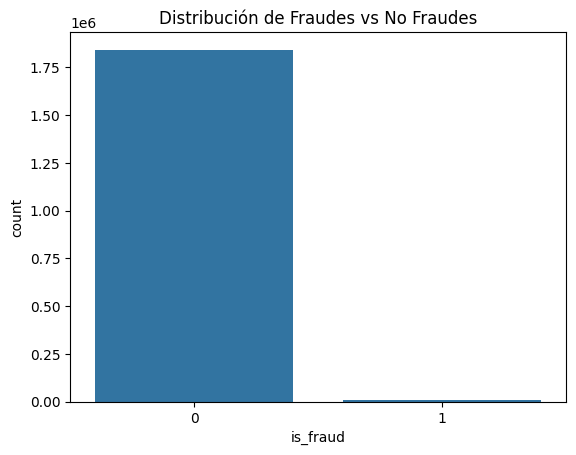

In [6]:
# Distribución
fraud_ratio = df['is_fraud'].value_counts(normalize=True)
print("Distribución de fraudes:")
print(fraud_ratio)

sns.countplot(x='is_fraud', data=df)
plt.title('Distribución de Fraudes vs No Fraudes')
plt.show()


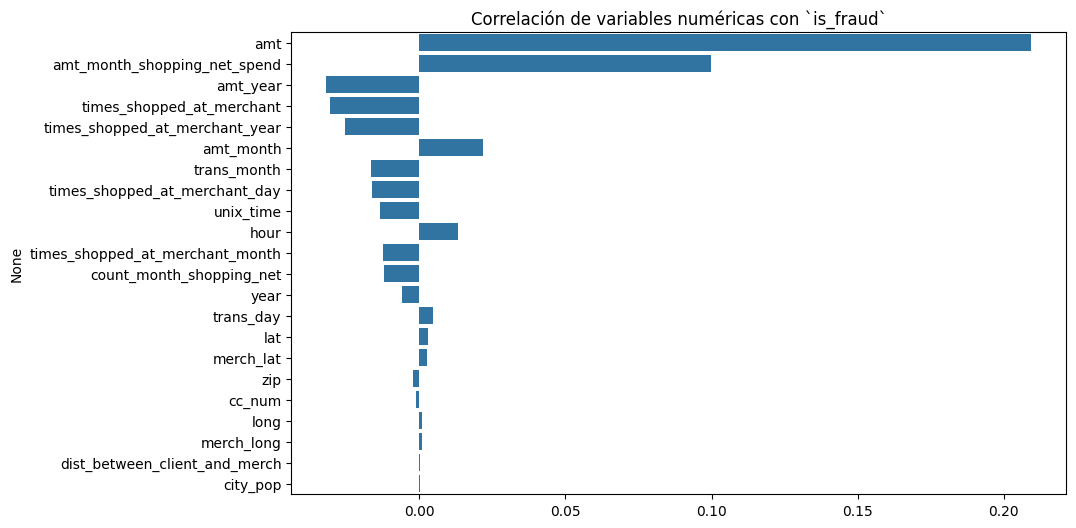

In [7]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['is_fraud'])
corr = numeric_cols.corrwith(df['is_fraud']).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlación de variables numéricas con `is_fraud`")
plt.show()


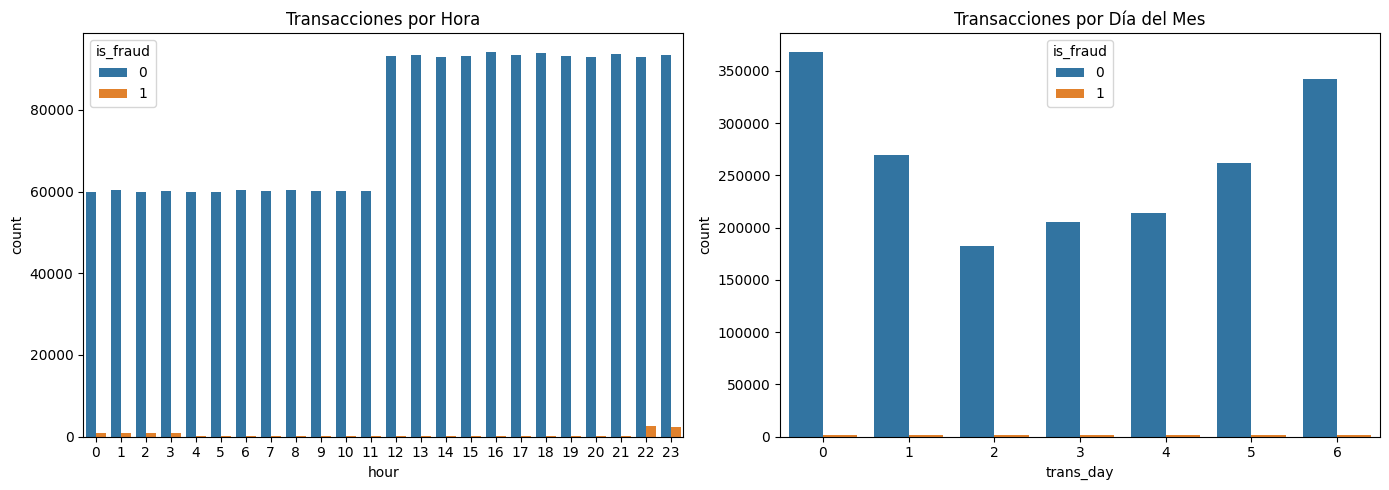

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='hour', hue='is_fraud', data=df, ax=ax[0])
ax[0].set_title('Transacciones por Hora')

sns.countplot(x='trans_day', hue='is_fraud', data=df, ax=ax[1])
ax[1].set_title('Transacciones por Día del Mes')

plt.tight_layout()
plt.show()


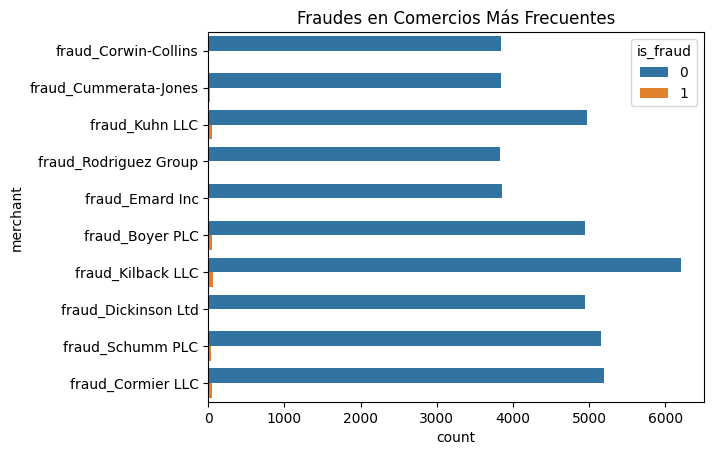

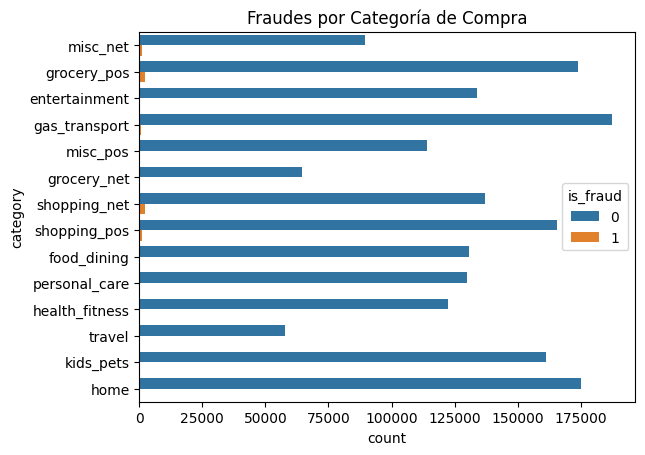

In [9]:
top_merchants = df['merchant'].value_counts().head(10).index
df_top = df[df['merchant'].isin(top_merchants)]

sns.countplot(y='merchant', hue='is_fraud', data=df_top)
plt.title("Fraudes en Comercios Más Frecuentes")
plt.show()

sns.countplot(y='category', hue='is_fraud', data=df)
plt.title("Fraudes por Categoría de Compra")
plt.show()


In [10]:
# 1. FLAG DE PERFIL COMPLEJO
df['is_complex_profile'] = (
    (df['amt_year'] > 5000) & # El usuario ha gastado más de Q5000 en el año.
    (df['times_shopped_at_merchant_year'] > 10) & # El usuario ha comprado en un mismo comercio más de 10 veces en el año.
    (df['count_month_shopping_net'] > 5) # Ha realizado más de 5 compras online en el mes.
)

In [11]:
# Transacciones complejas legítimas
non_fraud_complex = df[(df['is_complex_profile']) & (df['is_fraud'] == 0)]
print(f"Transacciones complejas legítimas: {len(non_fraud_complex)}")


Transacciones complejas legítimas: 2964


In [12]:
# Tasa de fraude en perfiles complejos
print("\nTasa de fraude en perfiles complejos:")
print(df[df['is_complex_profile']]['is_fraud'].value_counts(normalize=True))


Tasa de fraude en perfiles complejos:
is_fraud
0    0.999326
1    0.000674
Name: proportion, dtype: float64


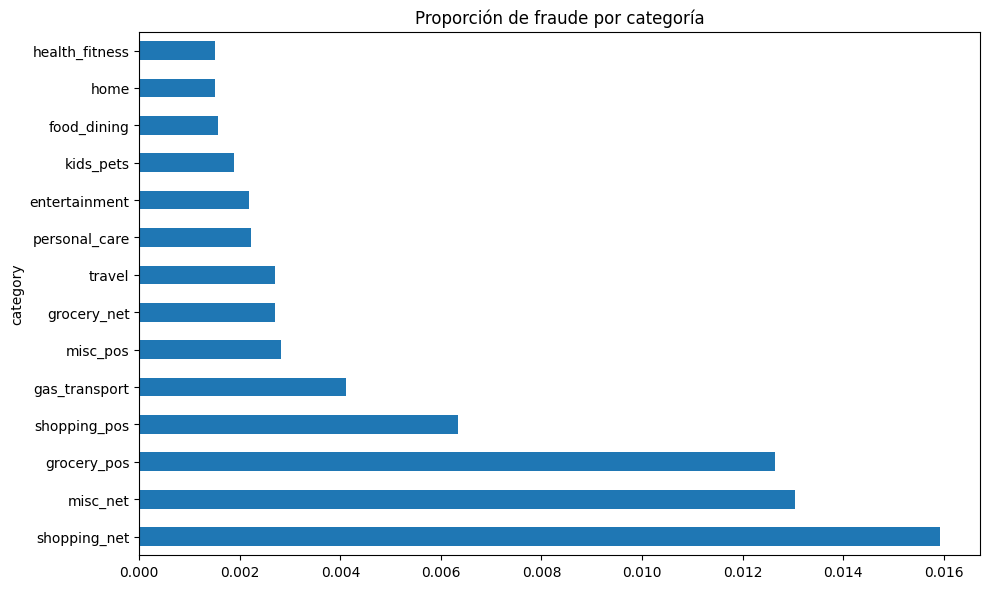

In [13]:
# Proporción de fraude por categoría
fraude_por_cat = df.groupby('category')['is_fraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
fraude_por_cat.plot(kind='barh', title='Proporción de fraude por categoría')
plt.tight_layout()
plt.show()

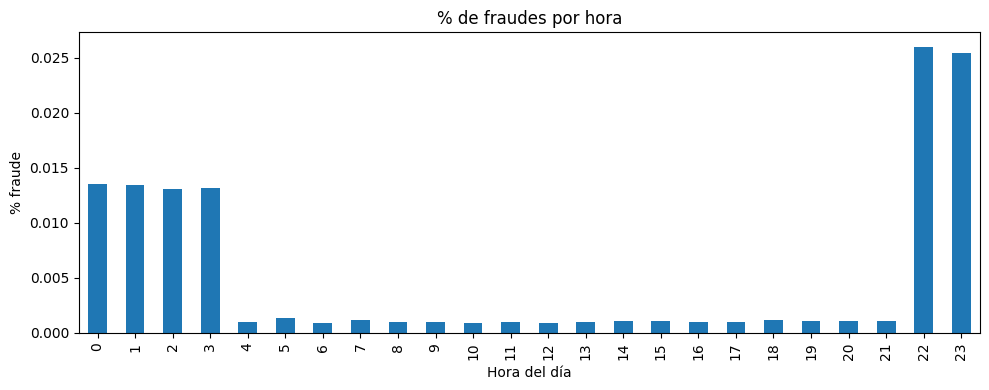

In [14]:
# Porcentaje de fraudes por hora
fraude_por_hora = df.groupby('hour')['is_fraud'].mean()
plt.figure(figsize=(10, 4))
fraude_por_hora.plot(kind='bar', title='% de fraudes por hora')
plt.ylabel('% fraude')
plt.xlabel('Hora del día')
plt.tight_layout()
plt.show()

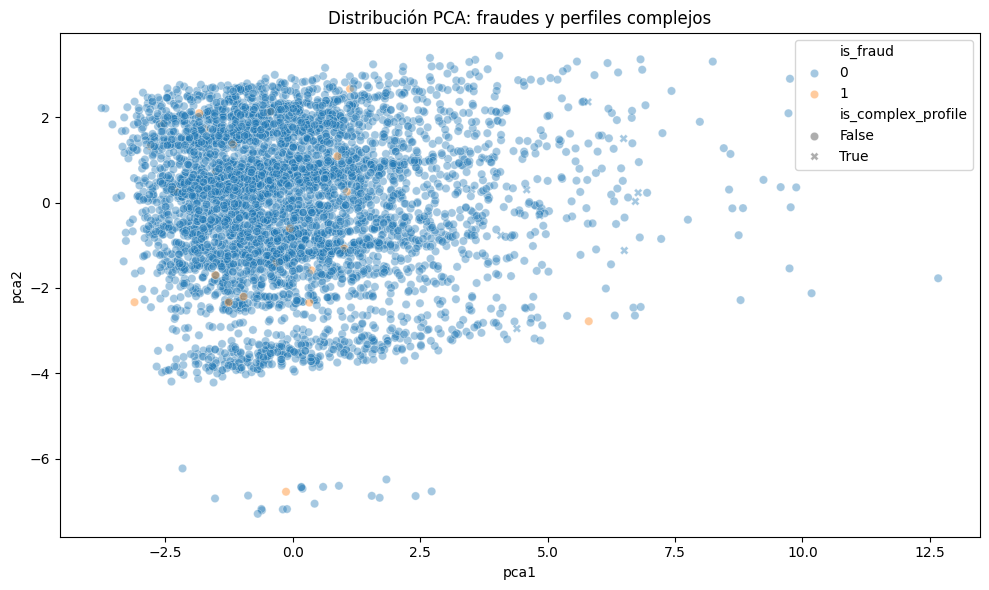

In [15]:
# Proyección PCA
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['is_fraud'])

X_scaled = StandardScaler().fit_transform(numeric_cols.fillna(0))
pca = PCA(n_components=2).fit_transform(X_scaled)

df['pca1'] = pca[:, 0]
df['pca2'] = pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(5000, random_state=42), x='pca1', y='pca2', hue='is_fraud',
                style='is_complex_profile', alpha=0.4)
plt.title("Distribución PCA: fraudes y perfiles complejos")
plt.tight_layout()
plt.show()

# FIN EDA

In [16]:
# 2. CONVERTIR CATEGÓRICAS, da error si no son categoricas
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

In [17]:
# 3. DIVISIÓN TEMPORAL
train_df = df[df['trans_month'] < 12].copy()
test_df  = df[df['trans_month'] == 12].copy()

X_train = train_df.drop(columns=['is_fraud'])
y_train = train_df['is_fraud']
X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']

In [18]:
# 4. FUNCIÓN DE EVALUACIÓN
def feval_penalty_fp_complex(preds, train_data):
    labels = train_data.get_label()
    preds_binary = (preds > 0.5).astype(int)
    complexity = train_data.get_weight()
    if complexity is None:
        complexity = np.zeros_like(labels)

    tp = ((labels == 1) & (preds_binary == 1)).sum()
    fp = ((labels == 0) & (preds_binary == 1)).astype(int)
    fp_penalized = (fp * (1 + complexity)).sum()

    score = tp / (tp + fp_penalized + 1e-6)
    return 'tp_over_penalized_fp', score, True

# F1 score penalizado por FP complejos
def feval_f1_fp_penalty(preds, train_data):
    labels = train_data.get_label()
    preds_binary = (preds > 0.5).astype(int)
    complexity = train_data.get_weight()
    if complexity is None:
        complexity = np.zeros_like(labels)

    tp = ((labels == 1) & (preds_binary == 1)).sum()
    fp = ((labels == 0) & (preds_binary == 1)).sum()
    fn = ((labels == 1) & (preds_binary == 0)).sum()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    fp_penalty = ((labels == 0) & (preds_binary == 1) & (complexity == 1)).sum()
    penalty_factor = fp_penalty / (tp + 1e-6)

    return 'f1_penalized', f1 - 0.1 * penalty_factor, True

# Precisión pura, penalizada por FP complejos
def feval_precision_boosted(preds, train_data):
    labels = train_data.get_label()
    preds_binary = (preds > 0.5).astype(int)
    complexity = train_data.get_weight()
    if complexity is None:
        complexity = np.zeros_like(labels)

    tp = ((labels == 1) & (preds_binary == 1)).sum()
    fp = ((labels == 0) & (preds_binary == 1)).sum()
    precision = tp / (tp + fp + 1e-6)

    fp_complex = ((labels == 0) & (preds_binary == 1) & (complexity == 1)).sum()
    penalty = 0.05 * fp_complex

    return 'precision_boosted', precision - penalty / (tp + 1e-6), True


def compute_scale_pos_weight(y, cap=300):
    """
    Calcula el scale_pos_weight dinámicamente y lo limita a un máximo razonable.
    
    Args:
        y (array-like): Vector de etiquetas (0 y 1).
        cap (float): Valor máximo permitido para evitar sobreajuste.

    Returns:
        float: Valor final a usar en scale_pos_weight.
    """
    count_neg = np.sum(np.array(y) == 0)
    count_pos = np.sum(np.array(y) == 1)
    if count_pos == 0:
        raise ValueError("No hay muestras positivas (fraudes) en los datos.")
    weight = count_neg / count_pos
    capped_weight = min(weight, cap)
    print(f"scale_pos_weight calculado: {weight:.2f} → usado: {capped_weight:.2f}")
    return capped_weight


In [19]:
# 5. PREPARACIÓN DE DATOS PARA LIGHTGBM
# Guardamos la columna de pesos ANTES de eliminarla
weights = (~X_train['is_complex_profile']).astype(int) * 2 + 1

# Eliminamos la columna de perfil complejo del modelo
X_train_model = X_train.drop(columns=['is_complex_profile'])
X_test_model = X_test.drop(columns=['is_complex_profile'])

train_set = lgb.Dataset(X_train_model, label=y_train, weight=weights)
valid_set = lgb.Dataset(X_test_model, label=y_test)

fraud_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"scale_pos_weight calculado: {fraud_weight:.2f}")

scaled_weight = compute_scale_pos_weight(y_train, cap=300)

scale_pos_weight calculado: 177.59
scale_pos_weight calculado: 177.59 → usado: 177.59


In [20]:
# 6. PARÁMETROS DEL MODELO
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    # 'is_unbalance': True,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'scale_pos_weight': scaled_weight,  # compensar desbalance
    'seed': 42
}

In [21]:
# 7. ENTRENAMIENTO
model = lgb.train(
    params,
    train_set,
    valid_sets=[valid_set],
    num_boost_round=500,
    feval=feval_penalty_fp_complex,
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 8801, number of negative: 1562995
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8453
[LightGBM] [Info] Number of data points in the train set: 1571796, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005604 -> initscore=-5.178642
[LightGBM] [Info] Start training from score -5.178642
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.977477	valid_0's tp_over_penalized_fp: 0.154915
[100]	valid_0's auc: 0.973481	valid_0's tp_over_penalized_fp: 0.251202
Early 

In [22]:
# 8. EVALUACIÓN FINAL
# Umbral personalizado
def custom_threshold(preds_proba, is_complex, threshold_simple=0.5, threshold_complex=0.7):
    return np.where(
        is_complex,
        preds_proba > threshold_complex,
        preds_proba > threshold_simple
    ).astype(int)

preds_proba = model.predict(X_test_model)
preds_bin = custom_threshold(preds_proba, X_test['is_complex_profile'])

# preds_bin = (preds_proba > 0.5).astype(int)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, preds_bin))

print("\nClassification Report:")
print(classification_report(y_test, preds_bin, digits=4))

Matriz de Confusión:
[[275900   3848]
 [   127    723]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9862    0.9928    279748
           1     0.1582    0.8506    0.2667       850

    accuracy                         0.9858    280598
   macro avg     0.5789    0.9184    0.6298    280598
weighted avg     0.9970    0.9858    0.9906    280598



In [23]:
# 9. Métrica personalizada para FP en perfiles complejos
def report_fp_complex(y_true, y_pred, is_complex):
    false_positives = (y_true == 0) & (y_pred == 1)
    fp_complex = false_positives & is_complex

    print(f"Falsos Positivos totales: {false_positives.sum()}")
    print(f"Falsos Positivos en perfiles complejos: {fp_complex.sum()}")
    print(f"Proporción de FP complejos: {fp_complex.sum() / (false_positives.sum() + 1e-6):.4f}")
report_fp_complex(y_test.values, preds_bin, X_test['is_complex_profile'].values)

Falsos Positivos totales: 3848
Falsos Positivos en perfiles complejos: 2
Proporción de FP complejos: 0.0005


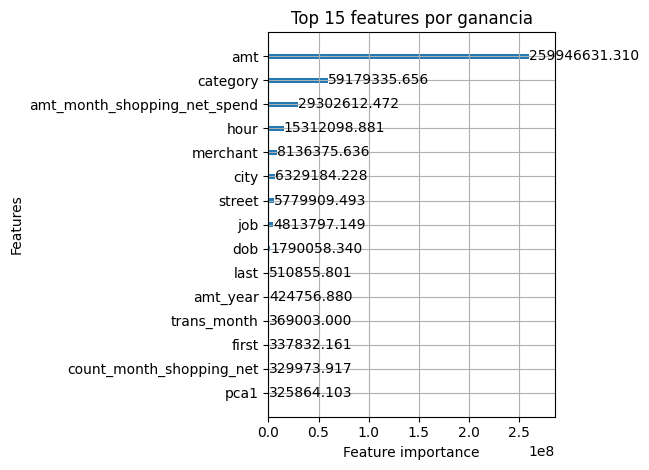

In [24]:
# 10. IMPORTANCIA DE VARIABLES
lgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.title("Top 15 features por ganancia")
plt.tight_layout()
plt.show()

In [25]:
# 11. COMPARACIÓN AUTOMÁTICA DE LAS 3 FUNCIONES
results = {}

for name, feval_fn in [
    ("penalty_fp_complex", feval_penalty_fp_complex),
    ("f1_fp_penalty", feval_f1_fp_penalty),
    ("precision_boosted", feval_precision_boosted),
]:
    print(f"\nEntrenando con métrica: {name}")
    
    model = lgb.train(
        params,
        train_set,
        valid_sets=[valid_set],
        num_boost_round=500,
        feval=feval_fn,
        callbacks=[
            lgb.early_stopping(50),
            lgb.log_evaluation(50)
        ]
    )

    preds_proba = model.predict(X_test_model)
    preds_bin = (preds_proba > 0.5).astype(int)

    print(f"\nResultados para {name}:")
    print(confusion_matrix(y_test, preds_bin))
    print(classification_report(y_test, preds_bin, digits=4))

    results[name] = {
        "model": model,
        "preds_bin": preds_bin,
        "preds_proba": preds_proba
    }


Entrenando con métrica: penalty_fp_complex
[LightGBM] [Info] Number of positive: 8801, number of negative: 1562995
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8453
[LightGBM] [Info] Number of data points in the train set: 1571796, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005604 -> initscore=-5.178642
[LightGBM] [Info] Start training from score -5.178642
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.977477	valid_0's tp_over_penalized_fp: 0.154915
[100]	valid_0's auc: 0.973481	valid_0's tp_over_penalized_fp: 0.251202
Early stopping, best iteration is:
[51]	valid_0's auc: 0.977728	valid_0's tp_over_penalized_fp: 0.158033

Resultados para penalty_fp_complex:
[[275896   3852]
 [   127    723]]
              precision    recall  f1-score   support

           0     0.9995  

In [26]:
y_pred_bin = results['penalty_fp_complex']['preds_bin']  # o cualquier otro
is_complex = X_test['is_complex_profile']

false_positives = (y_test == 0) & (y_pred_bin == 1)
print(f"FP complejos: {false_positives[is_complex].sum()} / {false_positives.sum()}")

FP complejos: 6 / 3852
